# Government Documents RAG System with LangGraph

This notebook demonstrates how to build a RAG (Retrieval-Augmented Generation) system for government documents using LangGraph and Claude.

## 1. Setup and Installation

First, let's install the required dependencies if they're not already installed:

In [ ]:
!pip install langchain-chroma chromadb unstructured sentence-transformers

In [1]:
import os
import getpass
from typing import Annotated, List, Dict, Any, TypedDict, Optional
from typing_extensions import TypedDict
import sys

# LangChain imports
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader, TextLoader
from langchain_community.vectorstores import Chroma
from langchain_chroma import Chroma as LCChroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_anthropic import ChatAnthropic
from langchain.schema import Document

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

## 2. Set API Keys

In [2]:
def set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

set_env("ANTHROPIC_API_KEY")

## 3. Document Processing

We'll create a class to handle loading and processing documents from a directory.

In [3]:
class DocumentProcessor:
    def __init__(self, docs_dir: str, chunk_size: int = 1000, chunk_overlap: int = 200):
        self.docs_dir = docs_dir
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=self.chunk_size,
            chunk_overlap=self.chunk_overlap,
            length_function=len,
        )
        
    def load_documents(self) -> List[Document]:
        """Load documents from the specified directory"""
        # Create directory if it doesn't exist
        if not os.path.exists(self.docs_dir):
            os.makedirs(self.docs_dir)
            print(f"Created directory: {self.docs_dir}")
            return []
            
        # Load PDFs
        pdf_loader = DirectoryLoader(self.docs_dir, glob="**/*.pdf", loader_cls=PyPDFLoader)
        # Load text files
        text_loader = DirectoryLoader(self.docs_dir, glob="**/*.txt", loader_cls=TextLoader)
        
        # Load the documents
        pdf_docs = pdf_loader.load() if any(f.endswith('.pdf') for f in os.listdir(self.docs_dir)) else []
        text_docs = text_loader.load() if any(f.endswith('.txt') for f in os.listdir(self.docs_dir)) else []
        
        # Combine all documents
        all_docs = pdf_docs + text_docs
        
        print(f"Loaded {len(all_docs)} documents")
        return all_docs
    
    def process_documents(self, documents: List[Document]) -> List[Document]:
        """Split documents into chunks for vectorization"""
        if not documents:
            print("No documents to process")
            return []
            
        chunked_documents = self.text_splitter.split_documents(documents)
        print(f"Split into {len(chunked_documents)} chunks")
        return chunked_documents

## 4. Vector Store Setup

Now let's create a vector store for document embeddings.

In [10]:
class VectorStore:
    def __init__(self, persist_directory: str = "./chroma_db"):
        self.persist_directory = persist_directory
        self.embeddings = HuggingFaceEmbeddings(
            model_name="all-MiniLM-L6-v2",
            model_kwargs={'device': 'cpu'},
        )
        self.vectordb = None
        
    def create_or_load_db(self, documents: Optional[List[Document]] = None) -> Chroma:
        """Create a new vector store or load existing one"""
        # Create directory if it doesn't exist
        if not os.path.exists(self.persist_directory):
            os.makedirs(self.persist_directory)
            
        if documents and len(documents) > 0:
            # Create a new vector store
            print(f"Creating new vector database with {len(documents)} documents")
            self.vectordb = LCChroma.from_documents(
                documents=documents,
                embedding=self.embeddings,
                persist_directory=self.persist_directory,
            )
            # The persist() call is no longer needed - removal fixes the error
            # LCChroma automatically persists when persist_directory is provided
            print(f"Vector database created and persisted to {self.persist_directory}")
        else:
            # Load existing vector store if it exists
            try:
                print(f"Loading existing vector database from {self.persist_directory}")
                self.vectordb = LCChroma(
                    persist_directory=self.persist_directory,
                    embedding_function=self.embeddings,
                )
                print(f"Successfully loaded vector database with {self.vectordb._collection.count()} documents")
            except Exception as e:
                print(f"Error loading existing database: {e}")
                print("Creating an empty vector database instead")
                self.vectordb = LCChroma(
                    embedding_function=self.embeddings,
                    persist_directory=self.persist_directory,
                )
        
        return self.vectordb
    
    def get_retriever(self, k: int = 4):
        """Get a retriever from the vector store"""
        if self.vectordb is None:
            raise ValueError("VectorDB not initialized. Call create_or_load_db first.")
        
        return self.vectordb.as_retriever(
            search_type="similarity",
            search_kwargs={"k": k}
        )

## 5. Create Sample Documents

Before we go further, let's create some sample government documents to test with. In a real system, you would use actual government documents.

In [11]:
# Create a directory for sample documents
sample_docs_dir = "./sample_government_docs"
if not os.path.exists(sample_docs_dir):
    os.makedirs(sample_docs_dir)

# Create sample documents
sample_docs = [
    {
        "filename": "education_policy_2024.txt",
        "content": """
# 2024 Education Policy Guidelines

## Introduction
This document outlines the government's education policy guidelines for 2024. These guidelines are designed to improve educational outcomes across all sectors.

## Key Initiatives
1. School Funding Increase: Additional $2 billion allocated to public schools nationwide.
2. Teacher Development Program: New training programs for 50,000 teachers.
3. Digital Learning Initiative: Providing tablets to students in underserved communities.
4. STEM Curriculum Enhancement: Updated science and technology curricula for grades 6-12.

## Implementation Timeline
- January 2024: Funding disbursement begins
- March 2024: Teacher development programs launch
- June 2024: Digital device distribution starts
- September 2024: New STEM curricula implemented

## Contact Information
For more information, contact the Department of Education at education@gov.example.org
"""
    },
    {
        "filename": "healthcare_reform_2024.txt",
        "content": """
# Healthcare Reform Act of 2024

## Executive Summary
The Healthcare Reform Act of 2024 aims to expand healthcare coverage to all citizens while reducing overall costs and improving quality of care.

## Major Provisions
1. Universal Coverage: Extension of basic health insurance to all citizens.
2. Prescription Drug Pricing: New regulations to cap prescription medication costs.
3. Rural Healthcare: $1.5 billion investment in rural hospital infrastructure.
4. Preventive Care: Expanded coverage for preventive services with no co-payments.
5. Mental Health Parity: Requirements for equal coverage of mental and physical health conditions.

## Funding Mechanisms
- 1% increase in employer healthcare contributions
- 0.5% tax on annual incomes over $500,000
- Pharmaceutical industry fees based on market share

## Implementation Schedule
- Phase 1 (July 2024): Prescription drug pricing controls
- Phase 2 (January 2025): Universal coverage enrollment begins
- Phase 3 (July 2025): Rural healthcare infrastructure grants

## Oversight
The new Healthcare Oversight Committee will monitor implementation and report quarterly to Congress.
"""
    },
    {
        "filename": "environmental_regulations_2024.txt",
        "content": """
# Environmental Protection Standards 2024

## Purpose
This document establishes updated environmental standards and regulations effective January 1, 2024.

## Emissions Standards
### Carbon Emissions
- Industrial facilities must reduce carbon emissions by 25% from 2023 levels by 2026.
- Automotive manufacturers must achieve fleet average of 45 MPG by 2025.
- Power plants must reduce emissions by 30% by 2027.

### Water Quality
- New limits on industrial discharge into waterways:
  - Heavy metals: maximum 0.01 ppm
  - Chemical oxygen demand: maximum 25 mg/L
  - Total suspended solids: maximum 30 mg/L

## Protected Areas
- 500,000 additional acres designated as protected wilderness
- Coastal development restrictions within 2 miles of shoreline
- Mining operations prohibited within 50 miles of national parks

## Renewable Energy Targets
- 40% of national energy from renewable sources by 2030
- Tax incentives for solar and wind energy implementation
- Grid modernization grants for states achieving 30% renewable energy

## Enforcement
The Environmental Protection Agency will conduct quarterly inspections with penalties of up to $1 million per violation.
"""
    }
]

# Write the sample documents to files
for doc in sample_docs:
    filepath = os.path.join(sample_docs_dir, doc["filename"])
    with open(filepath, "w") as f:
        f.write(doc["content"])
        
print(f"Created {len(sample_docs)} sample documents in {sample_docs_dir}")

Created 3 sample documents in ./sample_government_docs


## 6. Build the RAG System

In [12]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    retrieved_documents: Optional[List[Document]]

class GovernmentDocsRAG:
    def __init__(self, model_name: str = "claude-3-5-sonnet-20240620"):
        self.memory = MemorySaver()
        self.llm = ChatAnthropic(model=model_name)
        
        # Define system prompt for the chatbot
        self.system_prompt = """You are a helpful assistant specialized in answering questions about government documents. 
When responding:
1. Base your answers on the retrieved documents
2. If the documents don't contain the answer, say you don't know
3. Always cite your sources by referencing the document name and section
4. Be concise but thorough in your responses
5. Format your response in a readable way

Current retrieved documents for this query: {documents}
"""
        
        # Initialize the graph
        self.graph_builder = StateGraph(State)
        
    def build_graph(self, retriever):
        """Build the LangGraph flow"""
        # Define the retriever node
        def retrieve_documents(state: State) -> Dict[str, Any]:
            """Retrieve relevant documents based on the user query"""
            # Get the latest user message
            user_message = state["messages"][-1].content
            
            # Retrieve documents
            retrieved_docs = retriever.get_relevant_documents(user_message)
            
            # Format documents for better readability
            return {"retrieved_documents": retrieved_docs}
        
        # Define the RAG node
        def generate_response(state: State) -> Dict[str, Any]:
            """Generate a response using the LLM with retrieved documents"""
            # Get documents
            docs = state.get("retrieved_documents", [])
            
            # Format documents for the prompt
            doc_strings = []
            for i, doc in enumerate(docs):
                doc_strings.append(f"Document {i+1}:\nContent: {doc.page_content}\nSource: {doc.metadata.get('source', 'Unknown')}")
            
            formatted_docs = "\n\n".join(doc_strings)
            
            # Create prompt with documents
            messages = state["messages"].copy()
            
            # Add system prompt with documents
            system_prompt_with_docs = self.system_prompt.format(documents=formatted_docs)
            
            # Create augmented LLM
            llm_with_docs = self.llm.bind(system=system_prompt_with_docs)
            
            # Generate response
            return {"messages": [llm_with_docs.invoke(messages)]}
        
        # Add nodes to the graph
        self.graph_builder.add_node("retrieve", retrieve_documents)
        self.graph_builder.add_node("rag_response", generate_response)
        
        # Add edges
        self.graph_builder.add_edge(START, "retrieve")
        self.graph_builder.add_edge("retrieve", "rag_response")
        self.graph_builder.add_edge("rag_response", END)
        
        # Compile the graph
        self.graph = self.graph_builder.compile(checkpointer=self.memory)
        
        return self.graph
    
    def chat(self, user_input: str, thread_id: str = "default"):
        """Chat with the RAG system"""
        config = {"configurable": {"thread_id": thread_id}}
        
        result = self.graph.invoke(
            {"messages": [{"role": "user", "content": user_input}]},
            config,
        )
        
        # Return the AI's response
        return result["messages"][-1].content
    
    def get_conversation_history(self, thread_id: str = "default"):
        """Get the full conversation history"""
        config = {"configurable": {"thread_id": thread_id}}
        state = self.graph.get_state(config)
        
        # Return all messages if available
        if state and "messages" in state.values:
            return state.values["messages"]
        return []

## 7. Set Up the RAG Pipeline

In [13]:
# Process the sample documents
doc_processor = DocumentProcessor(docs_dir=sample_docs_dir)
raw_docs = doc_processor.load_documents()
processed_docs = doc_processor.process_documents(raw_docs)

Loaded 3 documents
Split into 5 chunks


In [14]:
# Set up the vector store
vector_store = VectorStore(persist_directory="./sample_government_docs_db")
vector_db = vector_store.create_or_load_db(documents=processed_docs)
retriever = vector_store.get_retriever(k=3)

Creating new vector database with 5 documents
Vector database created and persisted to ./sample_government_docs_db


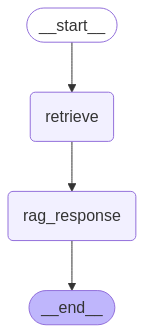

In [15]:
# Set up the RAG system
rag_system = GovernmentDocsRAG()
rag_system.build_graph(retriever)

## 8. Example Interactions

Let's interact with our RAG system by asking questions about the government documents.

In [16]:
# Example 1: Ask about education policy
question1 = "What is the budget allocation for public schools in 2024?"
print(f"Question: {question1}")
response1 = rag_system.chat(question1, thread_id="demo_session")
print(f"Response: {response1}")

Question: What is the budget allocation for public schools in 2024?


/tmp/ipykernel_2641/785899133.py:34: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(user_message)


Response: According to the 2024 Education Policy Guidelines, there is an additional $2 billion allocated to public schools nationwide. This is listed under the "Key Initiatives" section as the first item: "School Funding Increase: Additional $2 billion allocated to public schools nationwide." 

The implementation timeline indicates that the funding disbursement will begin in January 2024.

Source: sample_government_docs/education_policy_2024.txt, Key Initiatives and Implementation Timeline sections.


In [ ]:
# Example 2: Ask about healthcare reform
question2 = "What are the funding mechanisms for the Healthcare Reform Act?"
print(f"Question: {question2}")
response2 = rag_system.chat(question2, thread_id="demo_session")
print(f"Response: {response2}")

In [ ]:
# Example 3: Ask a follow-up question to test memory
question3 = "When will these funding mechanisms be implemented?"
print(f"Question: {question3}")
response3 = rag_system.chat(question3, thread_id="demo_session")
print(f"Response: {response3}")

In [ ]:
# Example 4: Ask about environmental regulations
question4 = "What are the new carbon emission targets for power plants?"
print(f"Question: {question4}")
response4 = rag_system.chat(question4, thread_id="demo_session")
print(f"Response: {response4}")

In [ ]:
# Example 5: Ask about something not in the documents
question5 = "What is the government's policy on international trade?"
print(f"Question: {question5}")
response5 = rag_system.chat(question5, thread_id="demo_session")
print(f"Response: {response5}")

## 9. Get Conversation History

Let's retrieve the full conversation history to verify that our memory is working.

In [ ]:
# Get conversation history
history = rag_system.get_conversation_history(thread_id="demo_session")
for i, message in enumerate(history):
    if message.role == "user":
        print(f"User: {message.content}")
    else:
        print(f"Assistant: {message.content[:100]}...")
    print("-" * 50)

## 10. Working with Your Own Government Documents

To use this system with your own government documents:

1. Create a directory for your documents
2. Add your PDF and/or text files to this directory
3. Update the document processor to point to your directory
4. Run the processing and vector store creation steps
5. Initialize the RAG system with your retriever

Here's a template for how you would do this:

In [ ]:
# Example: Set up with your own documents
'''
# Define your documents directory
my_docs_dir = "./my_government_docs"

# Process your documents
doc_processor = DocumentProcessor(docs_dir=my_docs_dir)
raw_docs = doc_processor.load_documents()
processed_docs = doc_processor.process_documents(raw_docs)

# Set up vector store with your documents
vector_store = VectorStore(persist_directory="./my_government_docs_db")
vector_db = vector_store.create_or_load_db(documents=processed_docs)
retriever = vector_store.get_retriever(k=4)

# Set up RAG system
rag_system = GovernmentDocsRAG()
rag_system.build_graph(retriever)

# Start interacting
response = rag_system.chat("What is the government's policy on X?", thread_id="my_session")
print(response)
'''